In [ ]:
import os
from tqdm import tqdm
import multiprocessing
import numpy as np
import cv2
import json
import yaml
import pandas as pd
import scipy.stats
import scipy.signal
import astropy.convolution
import matplotlib.pyplot as plt

import fm2p

Loading DLC 2.3.0...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


c:\Users\dmartins\.conda\envs\fm1\lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [2]:
cfg = r'C:\Data\dylan\Mini2P_data\250306_DMM_DMM038_pillar\preprocessed_config.yaml'
rname = 'fm1'

if type(cfg)==str:
    with open(cfg, 'r') as infile:
        cfg = yaml.load(infile, Loader=yaml.FullLoader)
rcfg = cfg[rname]

rpath = r'C:\Data\dylan\Mini2P_data\250306_DMM_DMM038_pillar\fm1'
eye_data = fm2p.read_h5(os.path.join(rpath, '250306_DMM_DMM038_fm_1_eye_tracking.h5'))
eyeT_startInd = rcfg['eyeT_startInd']
eyeT_endInd = rcfg['eyeT_endInd']

eyeT = eye_data['eyeT'][eyeT_startInd:eyeT_endInd]
theta = eye_data['theta'][eyeT_startInd:eyeT_endInd]
phi = eye_data['phi'][eyeT_startInd:eyeT_endInd]
puprad = eye_data['longaxis'][eyeT_startInd:eyeT_endInd]
longaxis = eye_data['longaxis'][eyeT_startInd:eyeT_endInd]
shortaxis = eye_data['shortaxis'][eyeT_startInd:eyeT_endInd]
centX = eye_data['X0'][eyeT_startInd:eyeT_endInd]
centY = eye_data['Y0'][eyeT_startInd:eyeT_endInd]

eyeT = eyeT.copy() - eyeT[0]

eyecam_deinter_video = os.path.join(rpath, '250306_DMM_DMM038_fm_1_eyecam_deinter.avi')
eyevid = fm2p.pack_video_frames(eyecam_deinter_video, dwnsmpl=1.)[eyeT_startInd:eyeT_endInd]

Reading 250306_DMM_DMM038_fm_1_eyecam_deinter.avi


100%|██████████| 97568/97568 [00:36<00:00, 2650.30it/s]


In [4]:
usemp = False

def sigmoid_curve(xval, a, b, c):
    curve = a + (b-a) / (1 + 10**((c - xval)*2))
    return curve

def sigmoid_fit(d):
    try:
        popt, pcov = scipy.optimize.curve_fit(
            sigmoid_curve,
            xdata=range(1,len(d)+1),
            ydata=d,
            p0=[100.0,200.0,len(d)/2],
            method='lm',
            xtol=10**-3,
            ftol=10**-3
        )
        ci = np.sqrt(np.diagonal(pcov))
    except RuntimeError:
        popt = np.nan * np.zeros(4)
        ci = np.nan * np.zeros(4)
    return (popt, ci)

In [5]:
# set up range of degrees in radians
rad_range = np.deg2rad(np.arange(360))

# for testing purposes, only test on 500 frames
totalF = np.size(eyevid, 0)
# frame_inds = np.arange(0, totalF)
frame_inds = np.arange(6000,12000)
set_size = (np.size(eyevid,2), np.size(eyevid,1)) # width, height

# set up for the multiprocessing that'll be used during sigmoid fit function
if usemp:
    print('Multiprocessing CPU count = {}'.format(multiprocessing.cpu_count()))
    n_proc = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(processes=n_proc)

print('Getting cross-section of pupil at each angle and fitting to sigmoid (SLOW!)')
all_raw_rfit = np.zeros([totalF, len(rad_range)]) * np.nan
all_conv_rfit = np.zeros([totalF, len(rad_range)]) * np.nan

key_error_count = 0

Getting cross-section of pupil at each angle and fitting to sigmoid (SLOW!)


In [45]:
for f in tqdm(frame_inds):
    try:
        img = eyevid[f,:,:].copy()

        # Range of values over mean radius
        ranger = 10
        meanr = 0.5 * (longaxis[f] + shortaxis[f])
        r = range(int(meanr - ranger), int(meanr + ranger))

        # Get cross-section of pupil at each angle 1-360 and fit to sigmoid
        pupil_edge = np.zeros([len(rad_range), len(r)])
        for i in range(0, len(r)):
            pupil_edge[:,i] = img[
                ((centY[f]+r[i]*np.sin(rad_range)).astype(int),
                 (centY[f]+r[i]*np.cos(rad_range)).astype(int))
            ]

        if usemp:
            # Apply sigmoid fit with multiprocessing. The result.get() is the slow process
            param_mp = [pool.apply_async(sigmoid_fit, args=(pupil_edge[n,:],)) for n in range(len(rad_range))]
            params_output = [result.get() for result in param_mp]
        elif not usemp:
            params_output = [sigmoid_fit(pupil_edge[n,:]) for n in range(len(rad_range))]

        # Unpack outputs of sigmoid fit
        params = []
        ci = []
        for vals in params_output:
            params.append(vals[0])
            ci.append(vals[1])
        params = np.stack(params)
        ci = np.stack(ci)

        # Extract radius variable from parameters
        rfit_raw = params[:,2] - 1

        # Drop frames based on confidence interval
        ci_temp = (ci[:,0]>5) | (ci[:,1]>5)  | (ci[:,2]>0.75)
        rfit_raw[ci_temp] = np.nan

        # Remove if luminance goes the wrong way
        # rfit_raw[(params[:,1] - params[:,0]) < 10] = np.nan
        # rfit_raw[params[:,1] > 250] = np.nan

        try:
            # Median filtered
            rfit_filt = fm2p.nanmedfilt(rfit_raw, 3).flatten() # was 5

            # Apply convolution
            filtsize = 25 # was 31
            rfit_conv_ = astropy.convolution.convolve(
                rfit_filt,
                np.ones(filtsize)/filtsize,
                boundary='wrap'
            )

            # Subtract baseline because our points aren't perfectly centered on ellipse
            rfit_conv = rfit_filt - rfit_conv_

        except ValueError as e: 
            # In case every value in rfit is NaN
            rfit_raw = np.zeros(len(rad_range)) * np.nan
            rfit_conv = np.zeros(len(rad_range)) * np.nan

    except (KeyError, ValueError) as e:
        key_error_count = key_error_count + 1
        rfit_raw = np.zeros(len(rad_range)) * np.nan
        rfit_conv = np.zeros(len(rad_range)) * np.nan

    # Get rid of outlier points
    rfit_conv[np.abs(rfit_conv)>3] = np.nan
    
    all_raw_rfit[f,:] = rfit_raw.copy()
    all_conv_rfit[f,:] = rfit_conv.copy()

  1%|▏         | 86/6000 [00:09<10:19,  9.55it/s]C:\Users\dmartins\AppData\Local\Temp\ipykernel_1980\905152016.py:9: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(
100%|██████████| 6000/6000 [11:19<00:00,  8.83it/s]


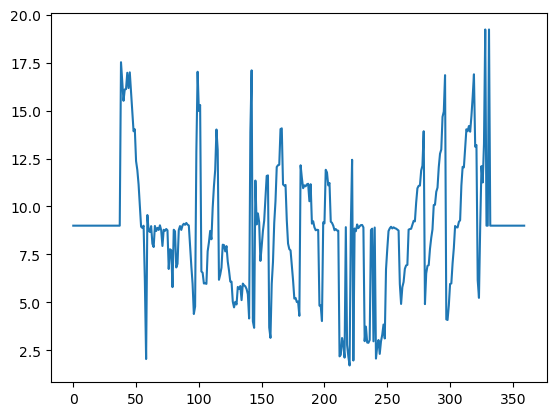

In [111]:
plt.plot(params[:,2] - 1)

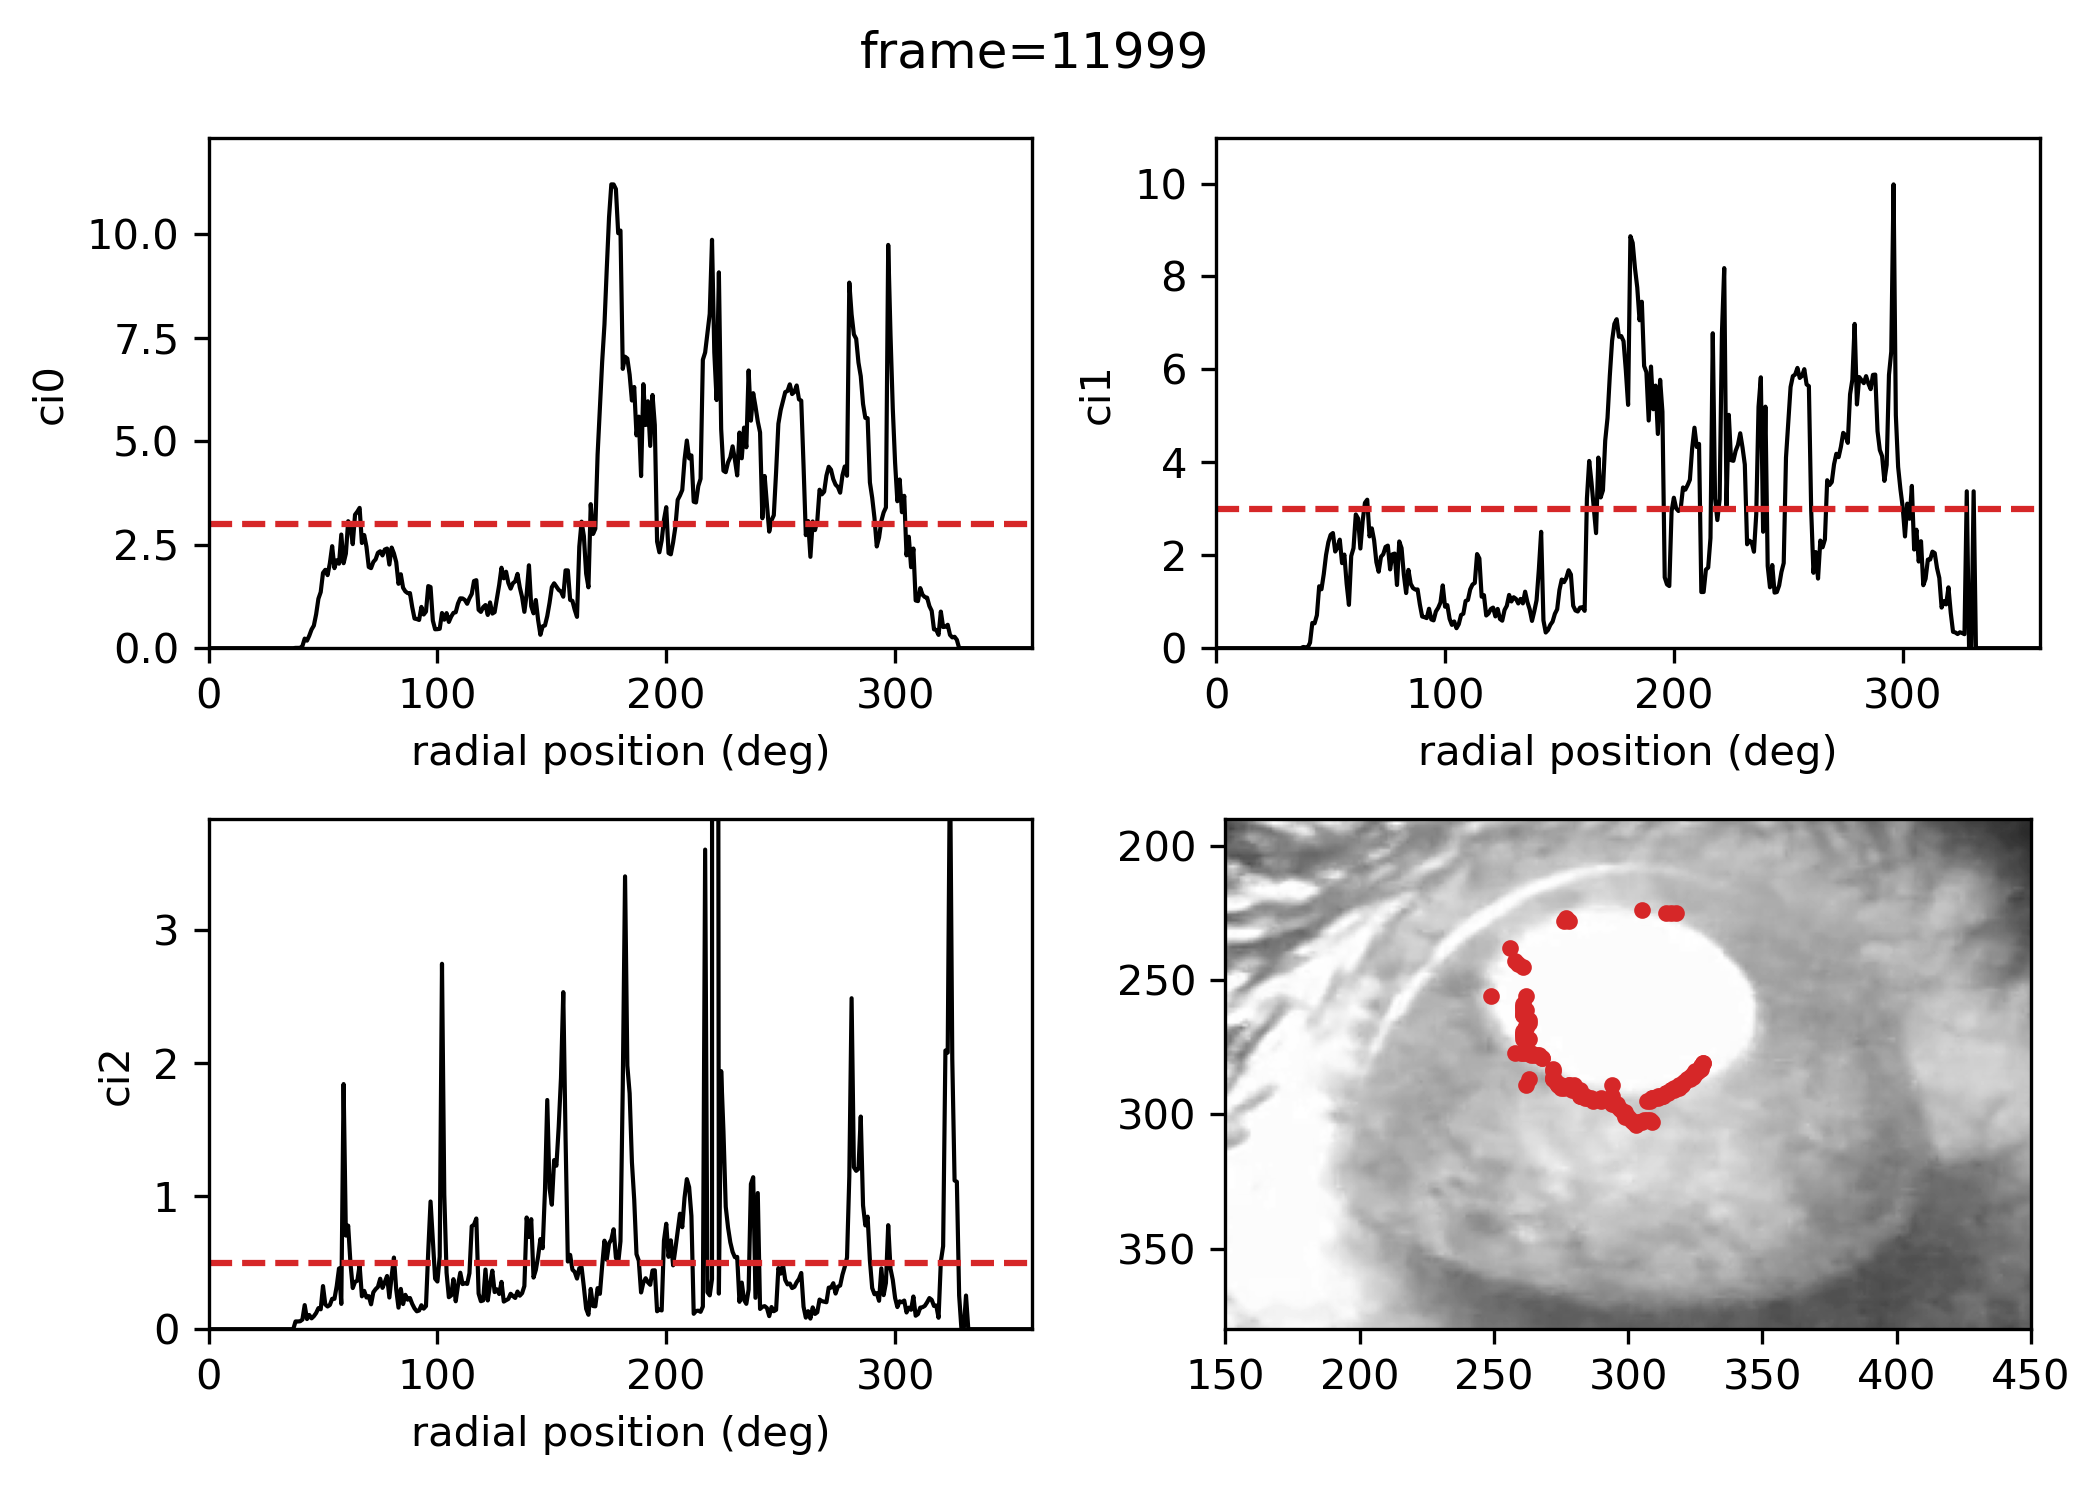

In [124]:
ci_threshs = [3, 3, 0.5] # 5, 5, 0.75
ci_temp = (ci[:,0]>ci_threshs[0]) | (ci[:,1]>ci_threshs[1])  | (ci[:,2]>ci_threshs[2])
rfit_temp = rfit_raw.copy()
rfit_temp[ci_temp] = np.nan

fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2, dpi=300, figsize=(7,5))

ax1.plot(ci[:,0], 'k-', lw=1)
ax1.hlines(ci_threshs[0], 0, 360, ls='--', color='tab:red')
ax1.set_xlim([0,360])
ax1.set_xlabel('radial position (deg)')
ax1.set_ylabel('ci0')
ax1.set_ylim([0,np.nanmax(ci[:,0])*1.1])

ax2.plot(ci[:,1], 'k-', lw=1)
ax2.hlines(ci_threshs[1], 0, 360, ls='--', color='tab:red')
ax2.set_xlim([0,360])
ax2.set_xlabel('radial position (deg)')
ax2.set_ylabel('ci1')
ax2.set_ylim([0,np.nanmax(ci[:,1])*1.1])

ax3.plot(ci[:,2], 'k-', lw=1)
ax3.hlines(ci_threshs[2], 0, 360, ls='--', color='tab:red')
ax3.set_xlim([0,360])
ax3.set_xlabel('radial position (deg)')
ax3.set_ylabel('ci2')
ax3.set_ylim([0,np.nanpercentile(ci[:,2],99)*1.1])

current_longaxis = longaxis[f]
current_shortaxis = shortaxis[f]
current_centX = centX[f]
current_centY = centY[f]

ax4.imshow(eyevid[f,:,:], cmap='gray')

# If more than 10% of radial positions have an identical value, set those to NaN
if (scipy.stats.mode(params[:,2] - 1).count / 360) > .10:
    ignore_pos = (params[:,2] - 1) != scipy.stats.mode(params[:,2] - 1).mode

# Plot the ellipse edge
rmin = 0.5 * (current_longaxis + current_shortaxis) - ranger

for deg_th, rad_th in enumerate(rad_range[ignore_pos]):

    edge_x = np.round(current_centX + (rmin + rfit_temp[deg_th]) * np.cos(rad_th))
    edge_y = np.round(current_centY + (rmin + rfit_temp[deg_th]) * np.sin(rad_th))

    if pd.isnull(edge_x) is False and pd.isnull(edge_y) is False:
        ax4.plot(int(edge_x),int(edge_y), '.', color='tab:red')
ax4.set_xlim([150,450])
ax4.set_ylim([380,190])

fig.suptitle('frame={}'.format(f))
fig.tight_layout()

In [47]:
# Correlation across first minute of recording
timepoint_corr_rfit = pd.DataFrame(all_conv_rfit[frame_inds[:3600]]).T.corr().to_numpy()

pupil_update = all_conv_rfit[frame_inds].copy()
total_shift = np.zeros(len(frame_inds))
peak = np.zeros(len(frame_inds)) * np.nan
c = total_shift.copy()
# Use mean as template
template = np.nanmean(all_conv_rfit[frame_inds].copy(), 0)

# xcorr of two random timepoints
tworandframes = False
while tworandframes is False:
    try:
        rind0 = np.random.random_integers(frame_inds[0], frame_inds[-2])
        rind1 = np.random.random_integers(frame_inds[0], frame_inds[-2])
        rfit2times_cc, rfit2times_lags = fm2p.nanxcorr(all_conv_rfit[rind0], all_conv_rfit[rind1], 11)
        tworandframes = True
    except ZeroDivisionError:
        pass

# Cross correlation between rand frame and the template
template_rfitconv_cc, template_rfit_cc_lags = fm2p.nanxcorr(all_conv_rfit[rind0], template, 30)

C:\Users\dmartins\AppData\Local\Temp\ipykernel_1980\4112011288.py:15: DeprecationWarning: This function is deprecated. Please call randint(6000, 11998 + 1) instead
  rind0 = np.random.random_integers(frame_inds[0], frame_inds[-2])
C:\Users\dmartins\AppData\Local\Temp\ipykernel_1980\4112011288.py:16: DeprecationWarning: This function is deprecated. Please call randint(6000, 11998 + 1) instead
  rind1 = np.random.random_integers(frame_inds[0], frame_inds[-2])


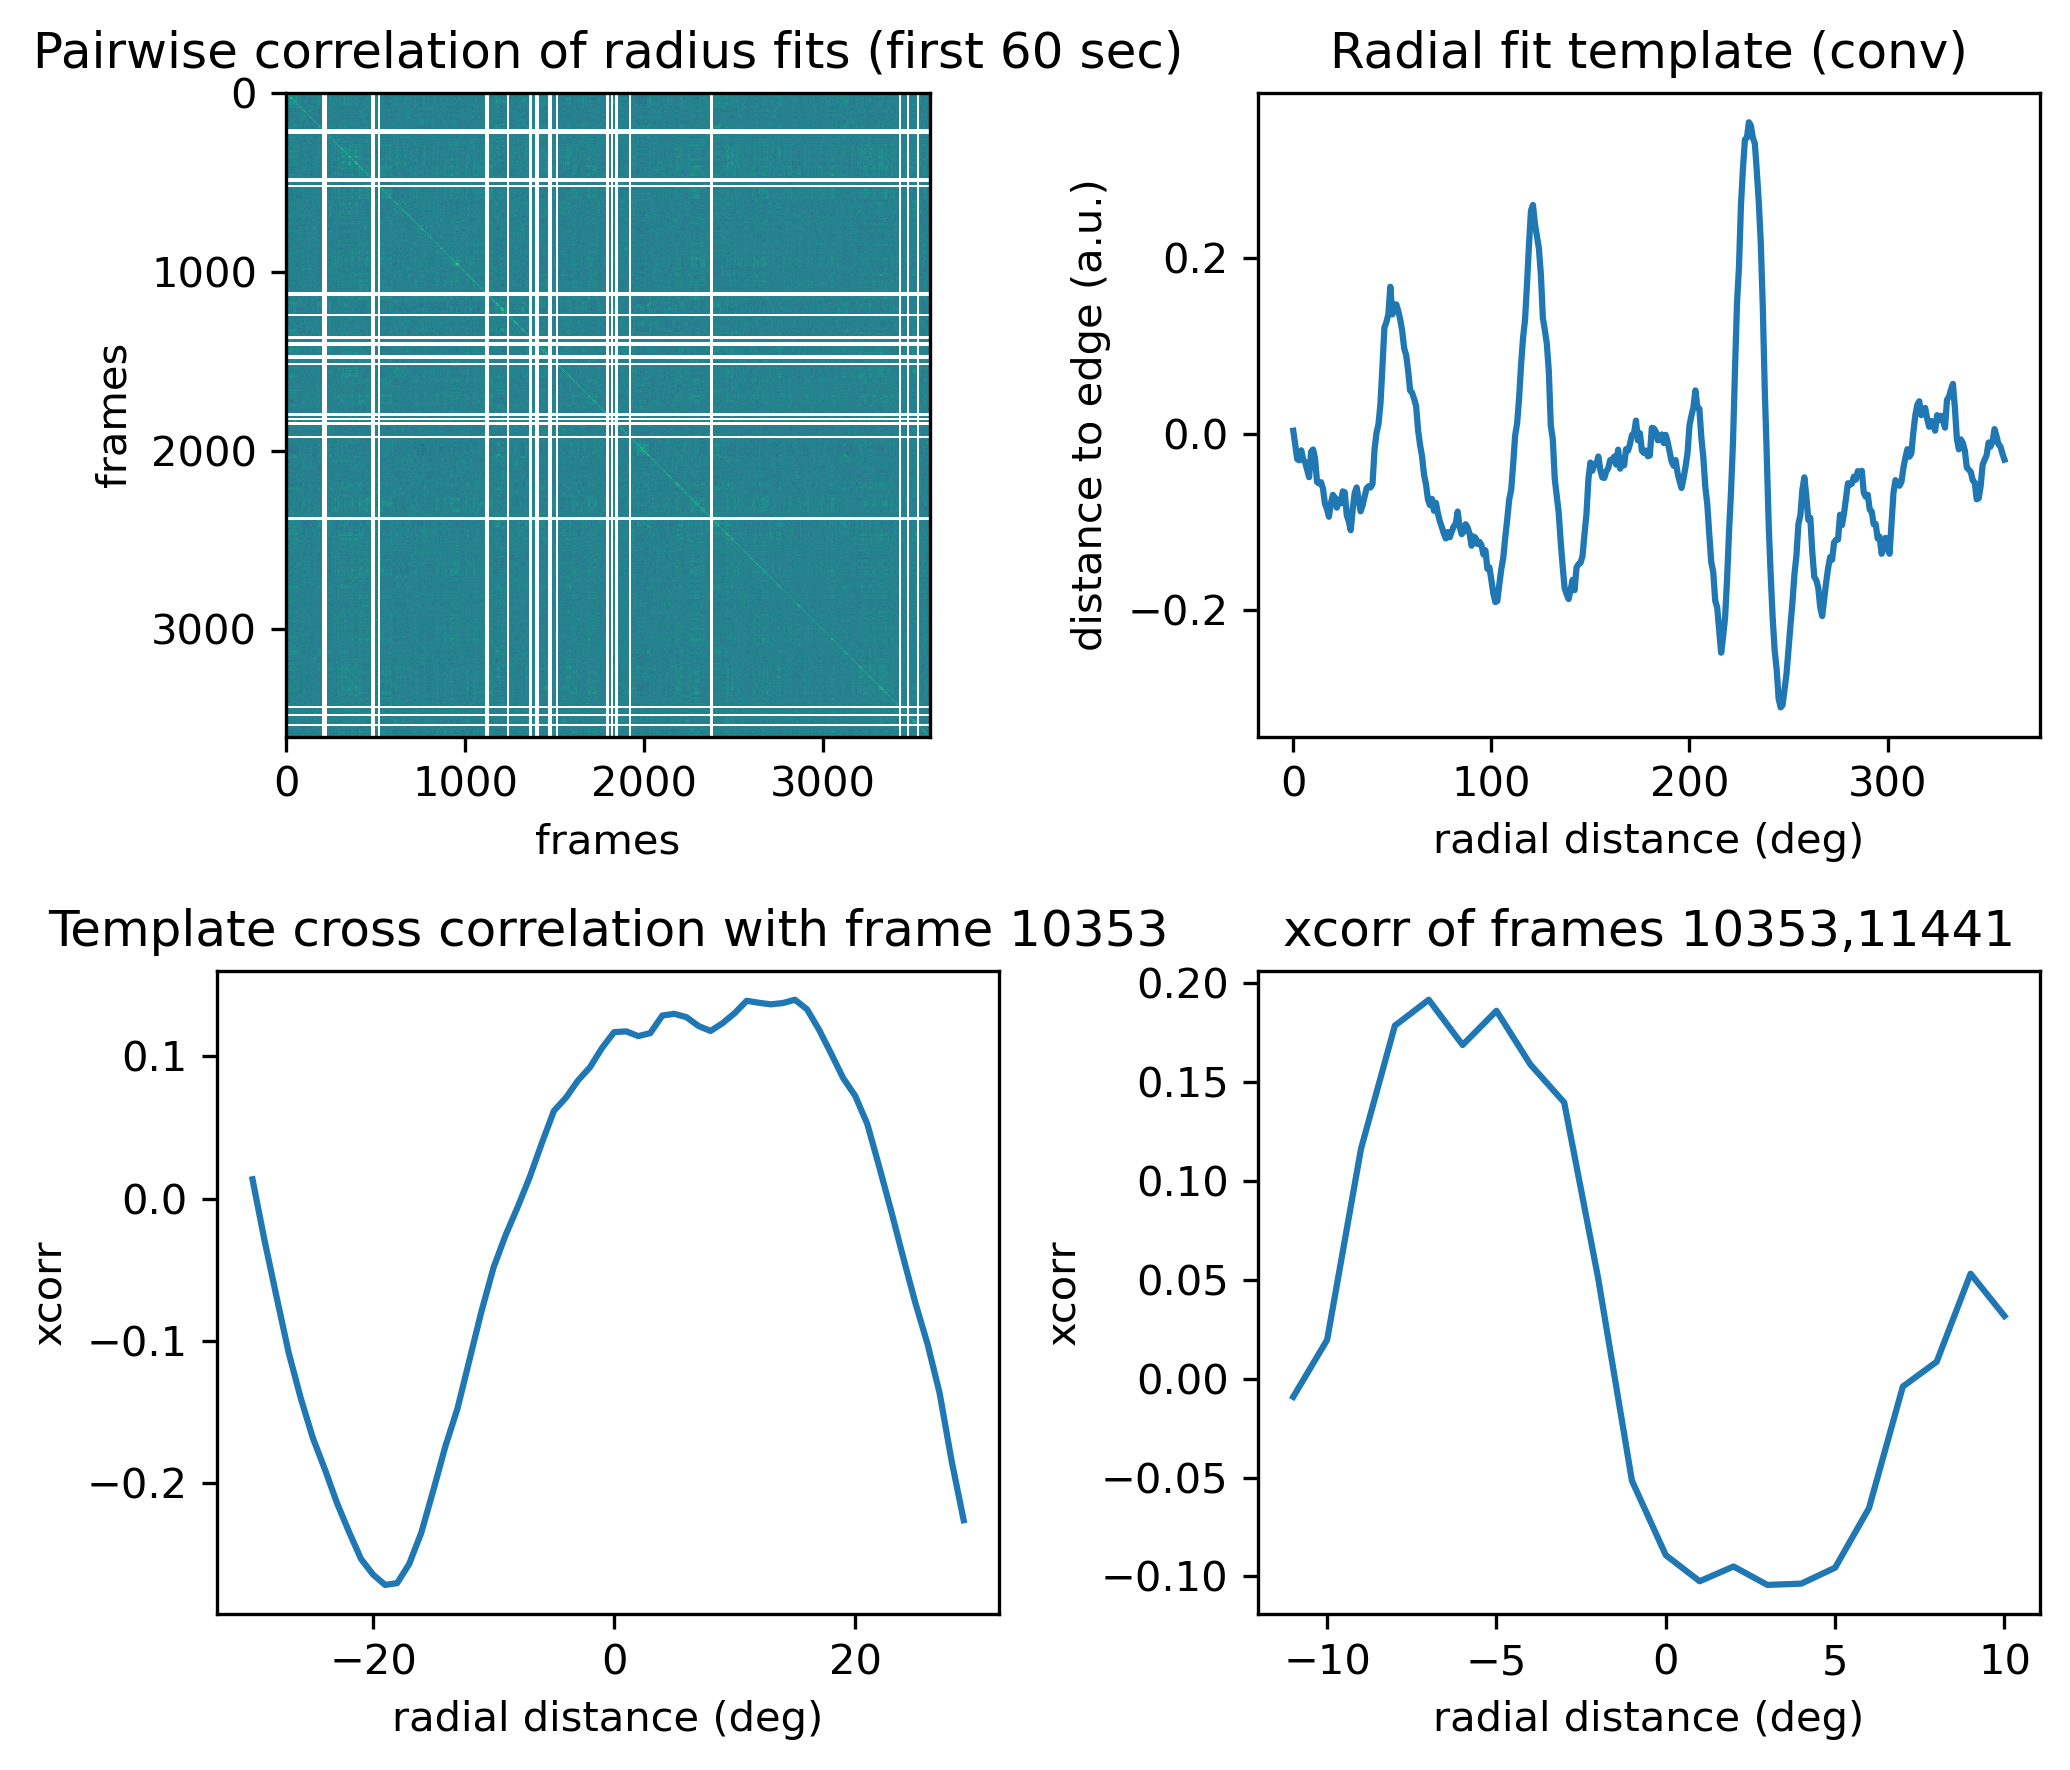

In [48]:
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2, dpi=300, figsize=(7,6))

im_ = ax1.imshow(timepoint_corr_rfit)
ax1.set_title('Pairwise correlation of radius fits (first 60 sec)')
ax1.set_xlabel('frames')
ax1.set_ylabel('frames')
# fig.colorbar(im_, ax=ax1, label='correlation')

ax2.plot(template)
ax2.set_title('Radial fit template (conv)')
ax2.set_xlabel('radial distance (deg)')
ax2.set_ylabel('distance to edge (a.u.)')

ax3.plot(template_rfit_cc_lags, template_rfitconv_cc)
ax3.set_xlabel('radial distance (deg)')
ax3.set_ylabel('xcorr')
ax3.set_title('Template cross correlation with frame {}'.format(rind0))

rindp0, rindp1 = sorted([rind0,rind1])
ax4.plot(rfit2times_lags, rfit2times_cc)
ax4.set_title('xcorr of frames {},{}'.format(rindp0, rindp1))
ax4.set_xlabel('radial distance (deg)')
ax4.set_ylabel('xcorr')

fig.tight_layout()

Shifting each frame to maximize xcorr with template.
Template is recalculated between each of 12 iterations.


  0%|          | 0/12 [00:00<?, ?it/s]c:\Users\dmartins\.conda\envs\fm1\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\dmartins\.conda\envs\fm1\lib\site-packages\numpy\core\_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount
c:\Users\dmartins\.conda\envs\fm1\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
100%|██████████| 12/12 [05:06<00:00, 25.51s/it]


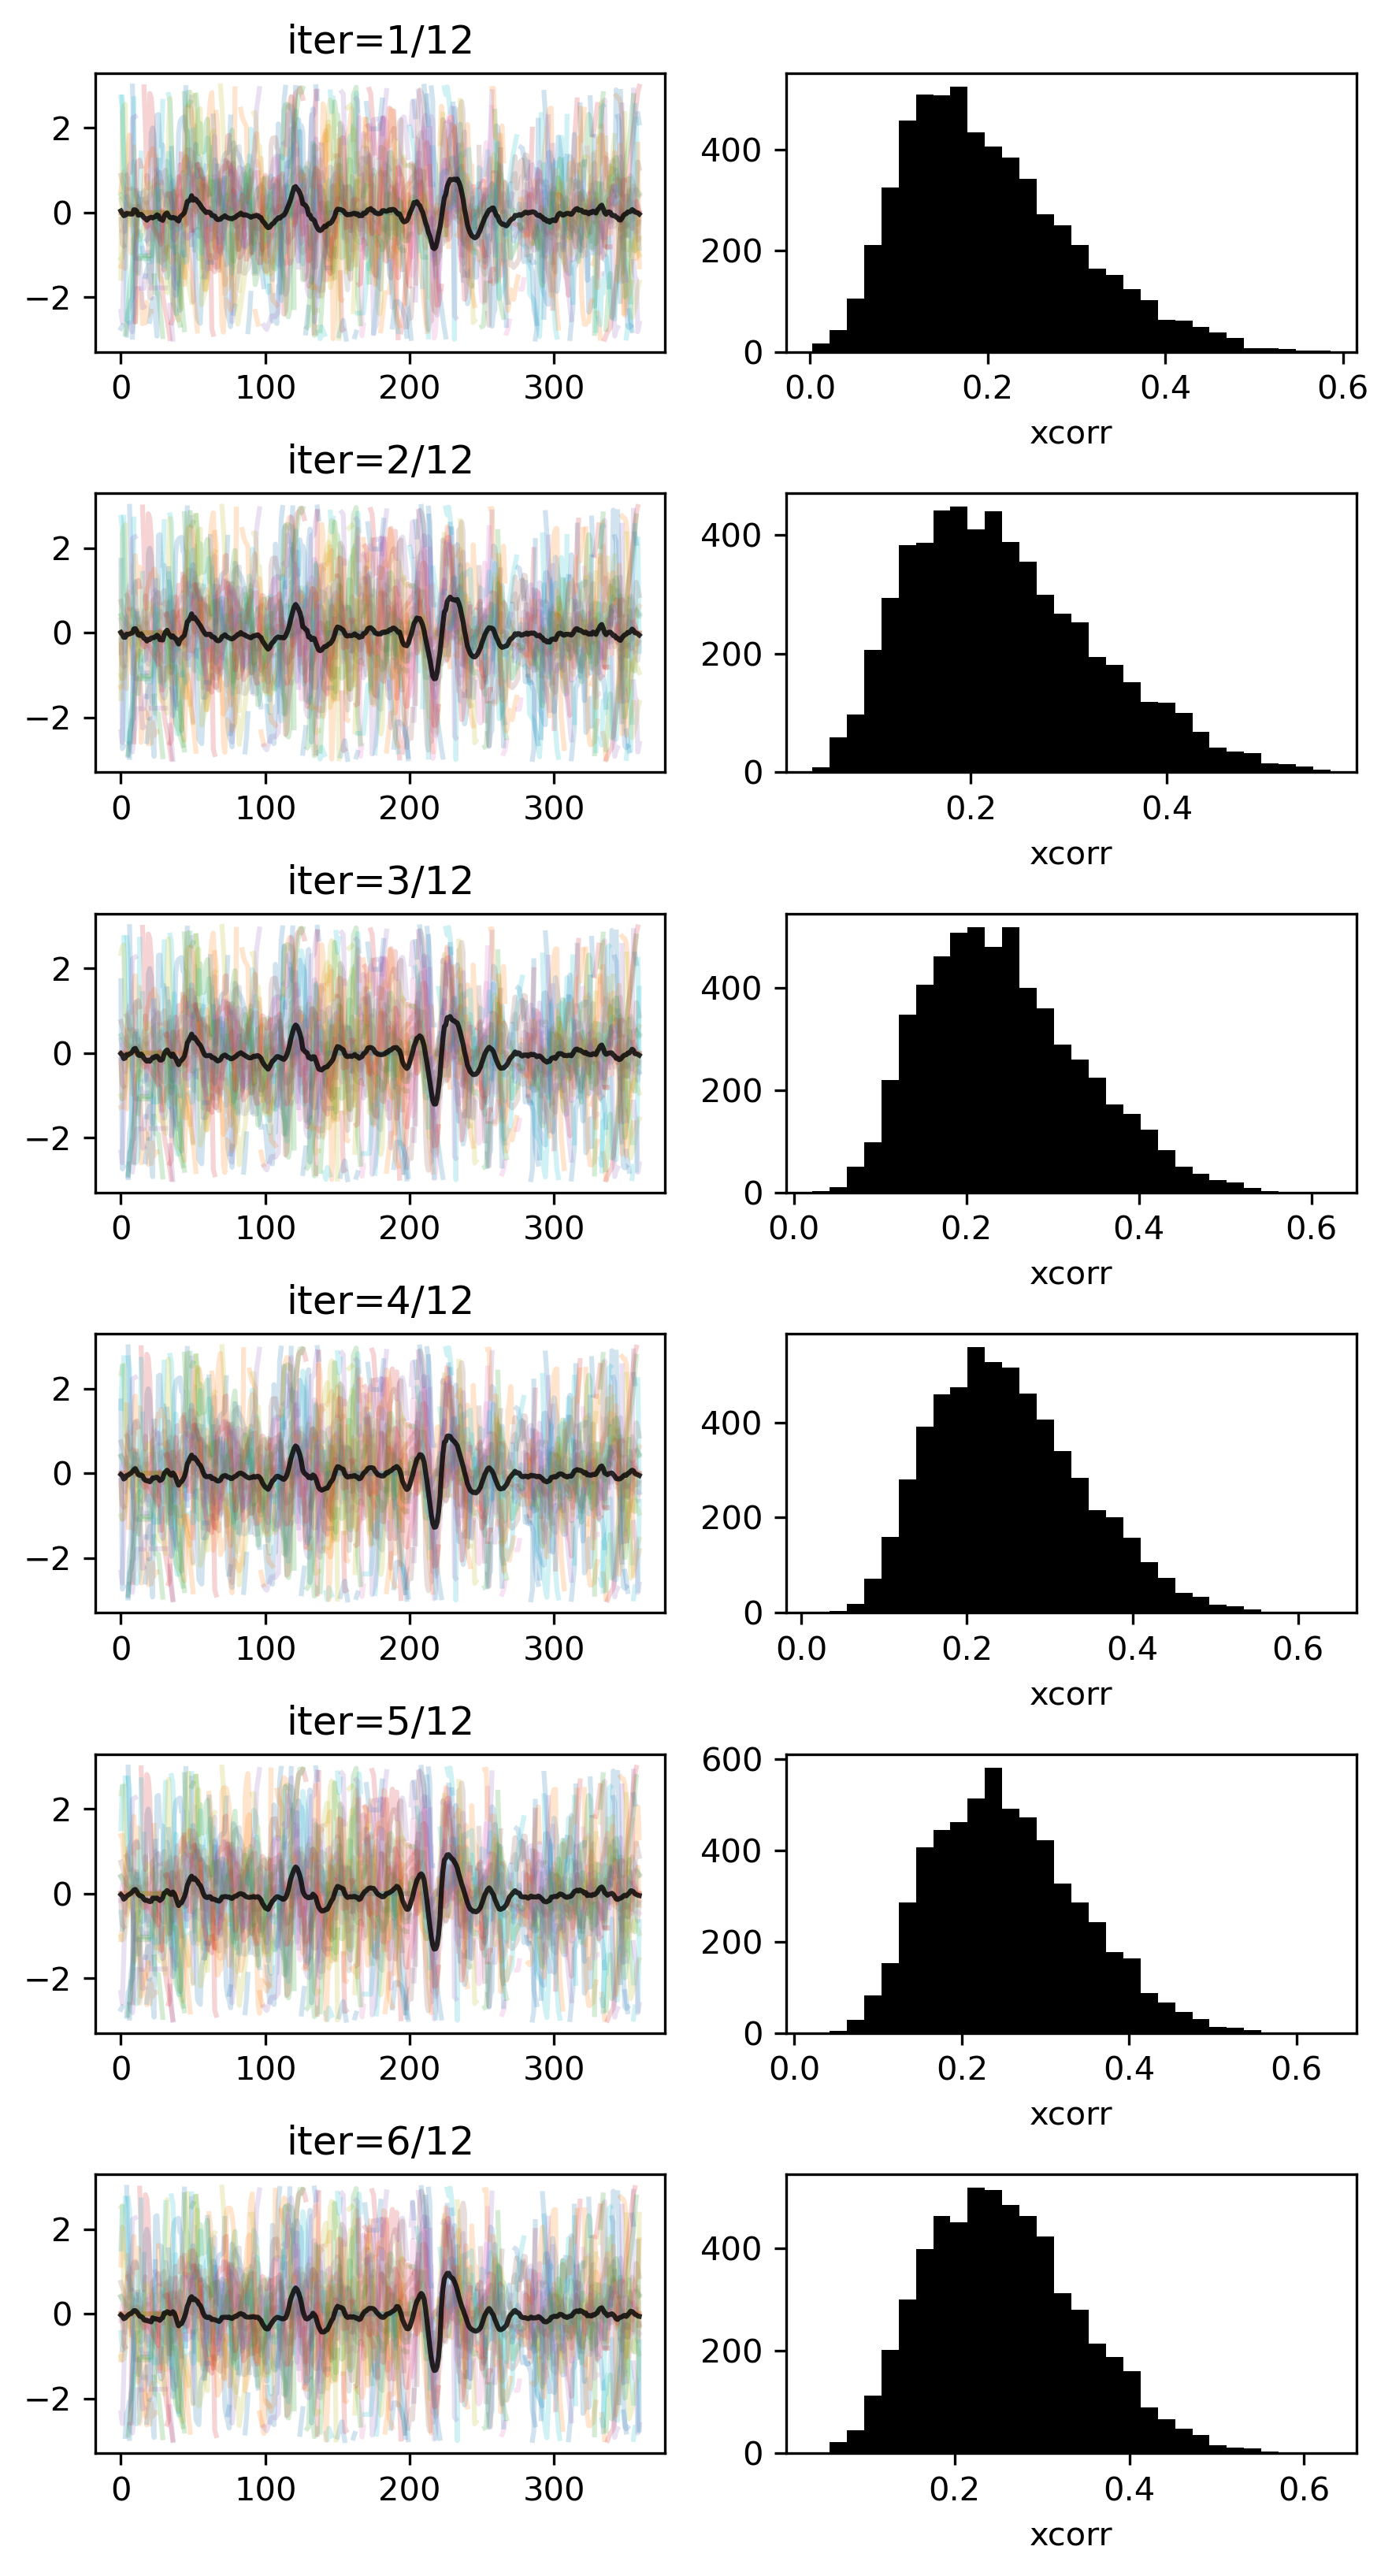

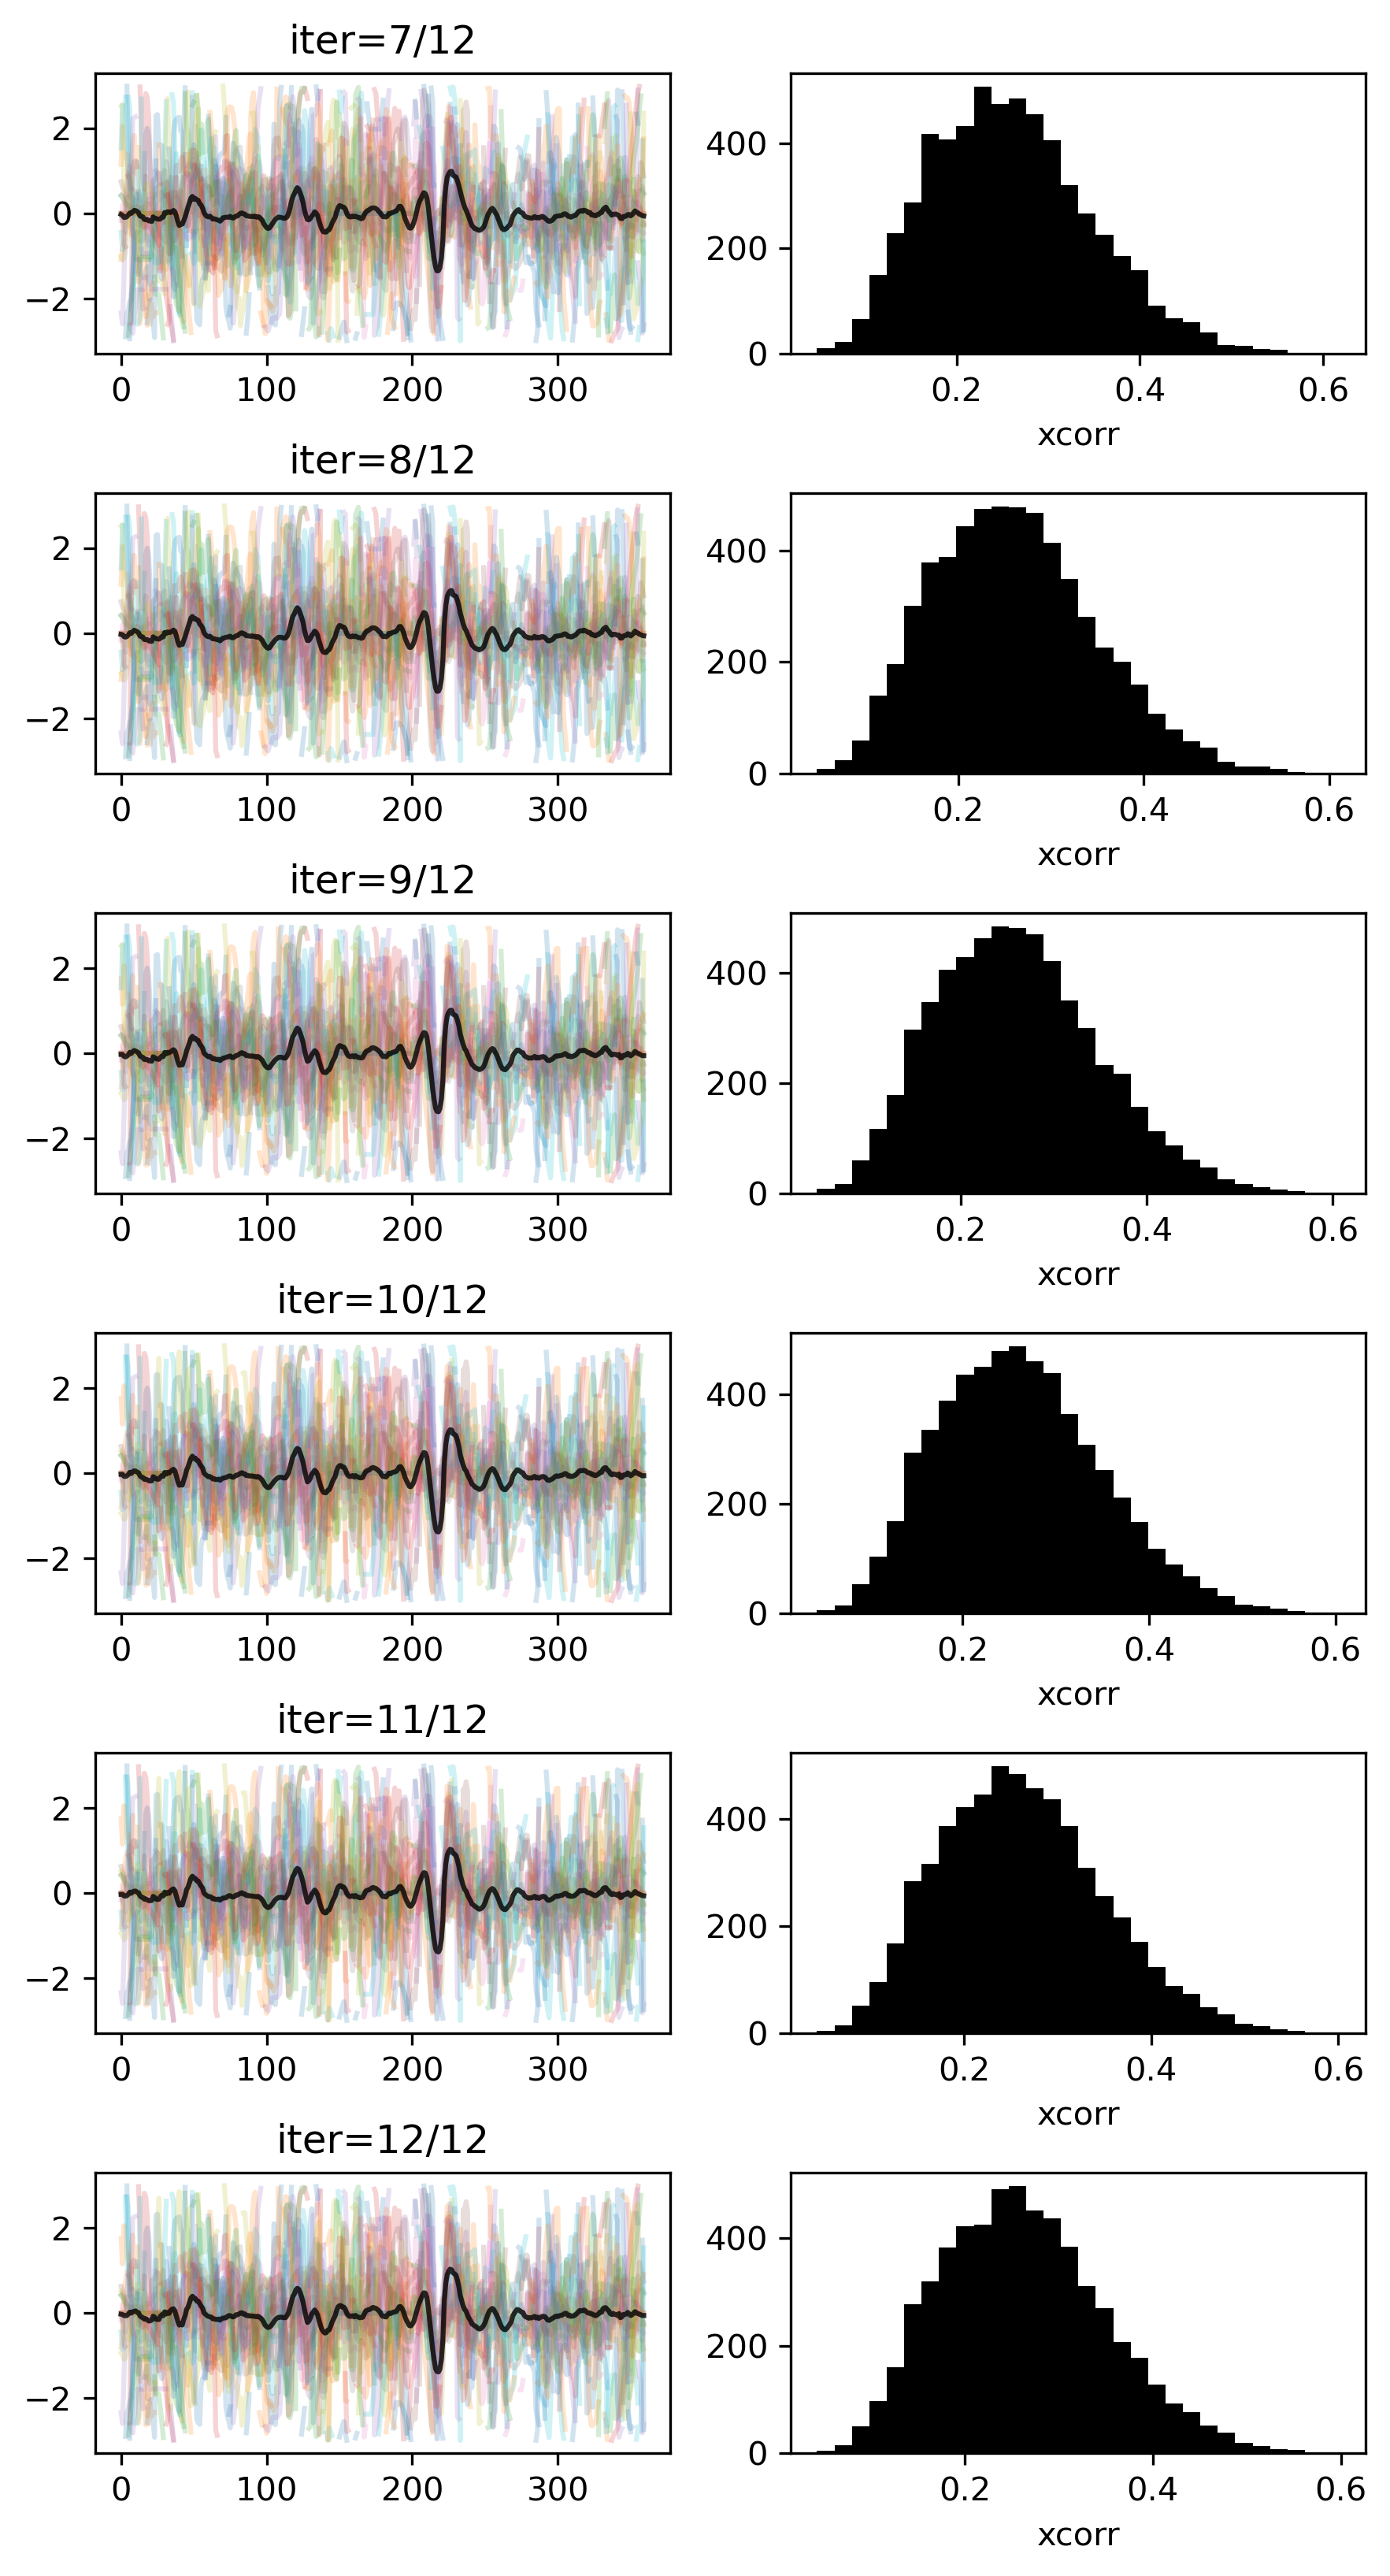

In [49]:
num_demo_cells = 25
ind2plot_rfit = sorted(np.random.randint(0, np.size(pupil_update,0), num_demo_cells))

# Iterative fit to alignment. Start with mean as template. On each of 12 iterations,
# shift individual frames to maximize cross-correlation with the template. Then,
# recalculate mean template.

fig1, axs1 = plt.subplots(6,2, dpi=300, figsize=(6,11))
fig2, axs2 = plt.subplots(6,2, dpi=300, figsize=(6,11))

print('Shifting each frame to maximize xcorr with template.\nTemplate is recalculated between each of 12 iterations.')
# twelve iterations
num_iter = 12
for rep in tqdm(range(num_iter)):

    # for each frame, get correlation, and shift
    # do all frames
    for f in range(np.size(pupil_update,0)):
        try:
            # Calc xcorr between frame's convolved rfit and current template
            xc, lags = fm2p.nanxcorr(template, pupil_update[f,:], 20)

            c[f] = np.amax(xc)
            peaklag = np.argmax(xc)
            # Find the shift distance that maximizes correlation between frame and template
            peak[f] = lags[peaklag]
            # Update cumulative total of shift distance across iterations (for this single frame)
            total_shift[f] = total_shift[f] + peak[f]
            # Apply the shift
            pupil_update[f,:] = np.roll(pupil_update[f,:], int(peak[f]))

        except ZeroDivisionError:
            total_shift[f] = np.nan
            pupil_update[f,:] = np.zeros(np.size(pupil_update,1)) * np.nan

    # Update template
    template = np.nanmean(pupil_update, axis=0)

    if rep<=5:
        ax1 = axs1[rep,0]
        ax2 = axs1[rep,1]
    elif rep>5:
        ax1 = axs2[rep-6,0]
        ax2 = axs2[rep-6,1]
    # Plot template with pupil_update for each iteration of fit
    ax1.set_title('iter={}/{}'.format(rep+1,num_iter))
    ax1.plot(pupil_update[ind2plot_rfit,:].T, alpha=0.2)
    ax1.plot(template, 'k-', alpha=0.8)

    # Histogram of correlations
    ax2.hist(c[c>0], bins=30, color='k') # gets rid of NaNs in plot
    ax2.set_xlabel('xcorr')

fig1.tight_layout()
fig2.tight_layout()
plt.show()

In [50]:
# Invert total shift so that it is a measure of the pupil's shift rather than a
# measure of the shift applied to reach the template
shift_nan = -total_shift.copy() # shift in degrees
# Only shift when correlation was high (prev. was c<0.35)
shift_nan[c < 0.25] = np.nan

shift_nan = shift_nan - np.nanmedian(shift_nan)

In [51]:
# Get rid of very large shifts
shift_nan[np.abs(shift_nan) >= 30] = np.nan

# Median filter to get rid of outliers
shift_smooth = scipy.signal.medfilt(shift_nan, 3)

# Convolve to smooth and fill in nans. Need radial convolution, since it's 0 to
# 360 degrees around the pupil
win = 5
shift_smooth = astropy.convolution.convolve(shift_nan, np.ones(win)/win)
shift_smooth = shift_smooth - np.nanmedian(shift_smooth)

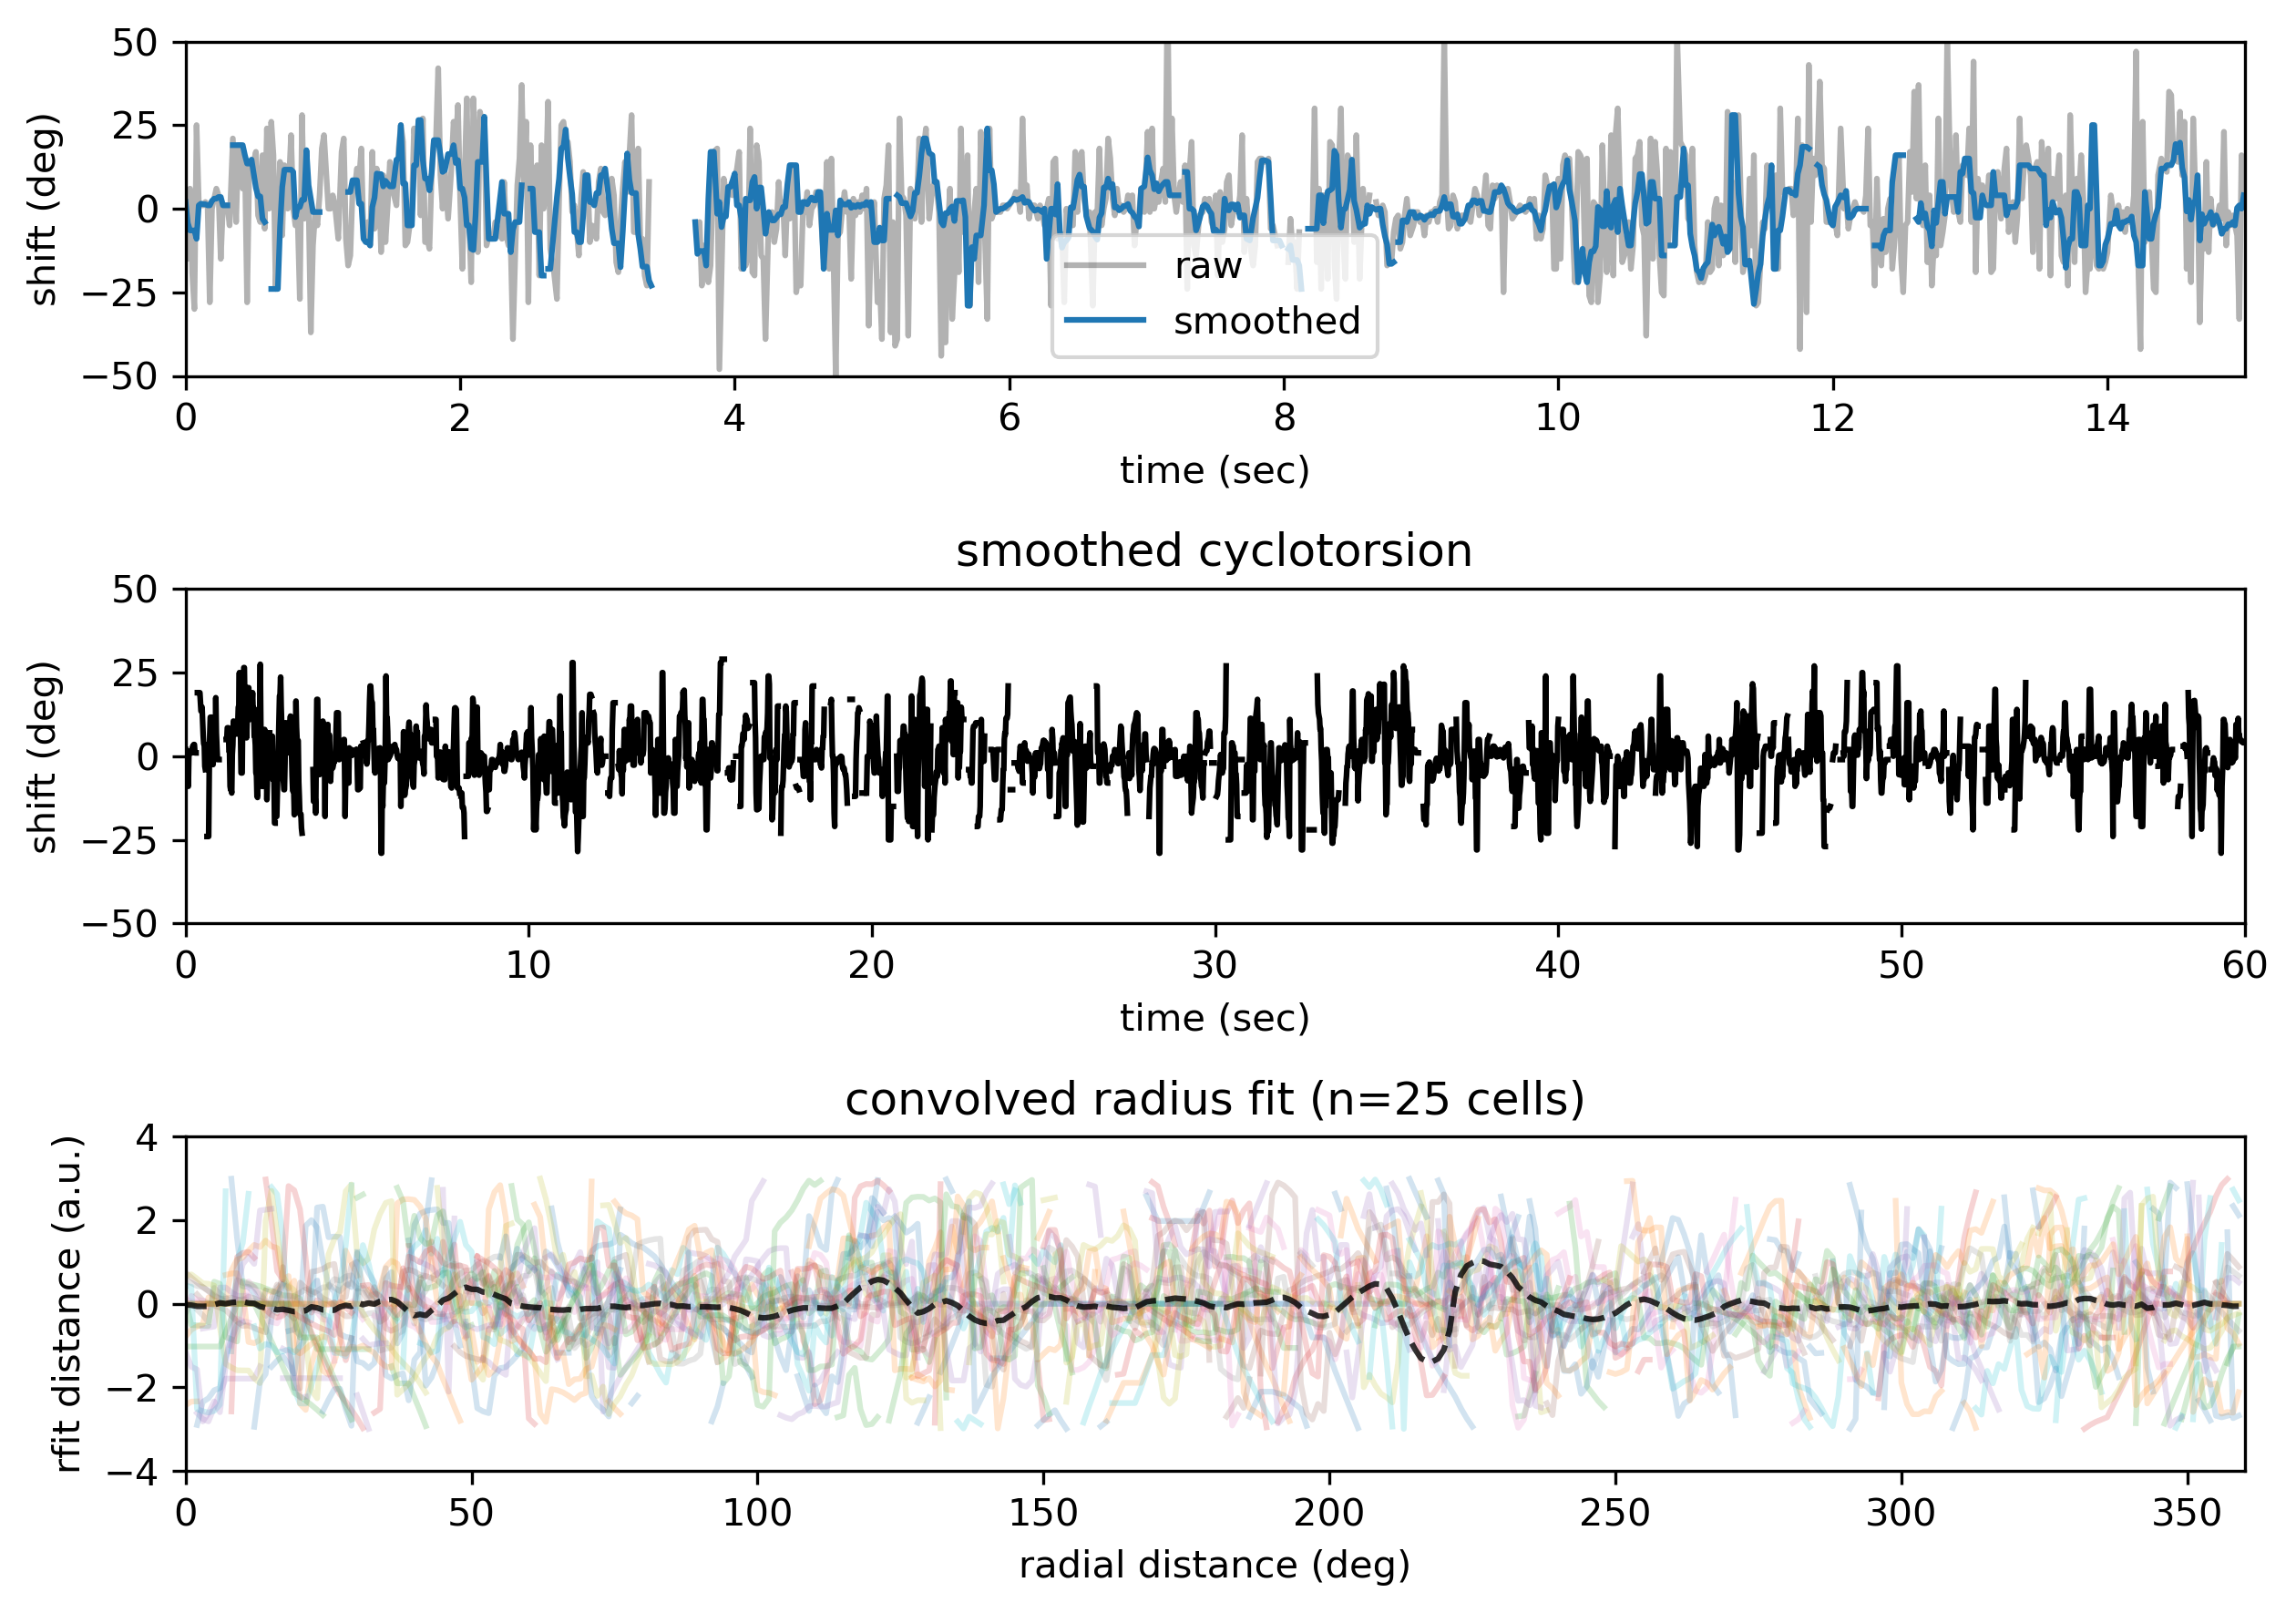

In [58]:
fig, [ax0,ax1,ax3] = plt.subplots(3,1, figsize=(8.5,6), dpi=300)

ax0.plot(eyeT[:900], -total_shift[:900], 'k', alpha=0.3, label='raw')
ax0.plot(eyeT[:900], shift_smooth[:900], color='tab:blue', label='smoothed')
ax0.set_xlim([0,15])
ax0.set_ylabel('shift (deg)')
ax0.set_xlabel('time (sec)')
ax0.legend()
ax0.set_ylim([-50,50])

ax1.plot(eyeT[:3600], shift_smooth[:3600], 'k')
ax1.set_ylabel('shift (deg)')
ax1.set_xlabel('time (sec)')
ax1.set_title('smoothed cyclotorsion')
ax1.set_xlim([0,60])
ax1.set_ylim([-50,50])

for f in ind2plot_rfit:
    ax3.plot(np.arange(360), all_conv_rfit[frame_inds][f,:].T, alpha=0.2)
ax3.plot(np.arange(360), template, 'k--', alpha=0.8)
ax3.set_ylabel('rfit distance (a.u.)')
ax3.set_xlabel('radial distance (deg)')
ax3.set_title('convolved radius fit (n={} cells)'.format(num_demo_cells))
ax3.set_xlim([0,360])
ax3.set_ylim([-4,4])

fig.tight_layout()

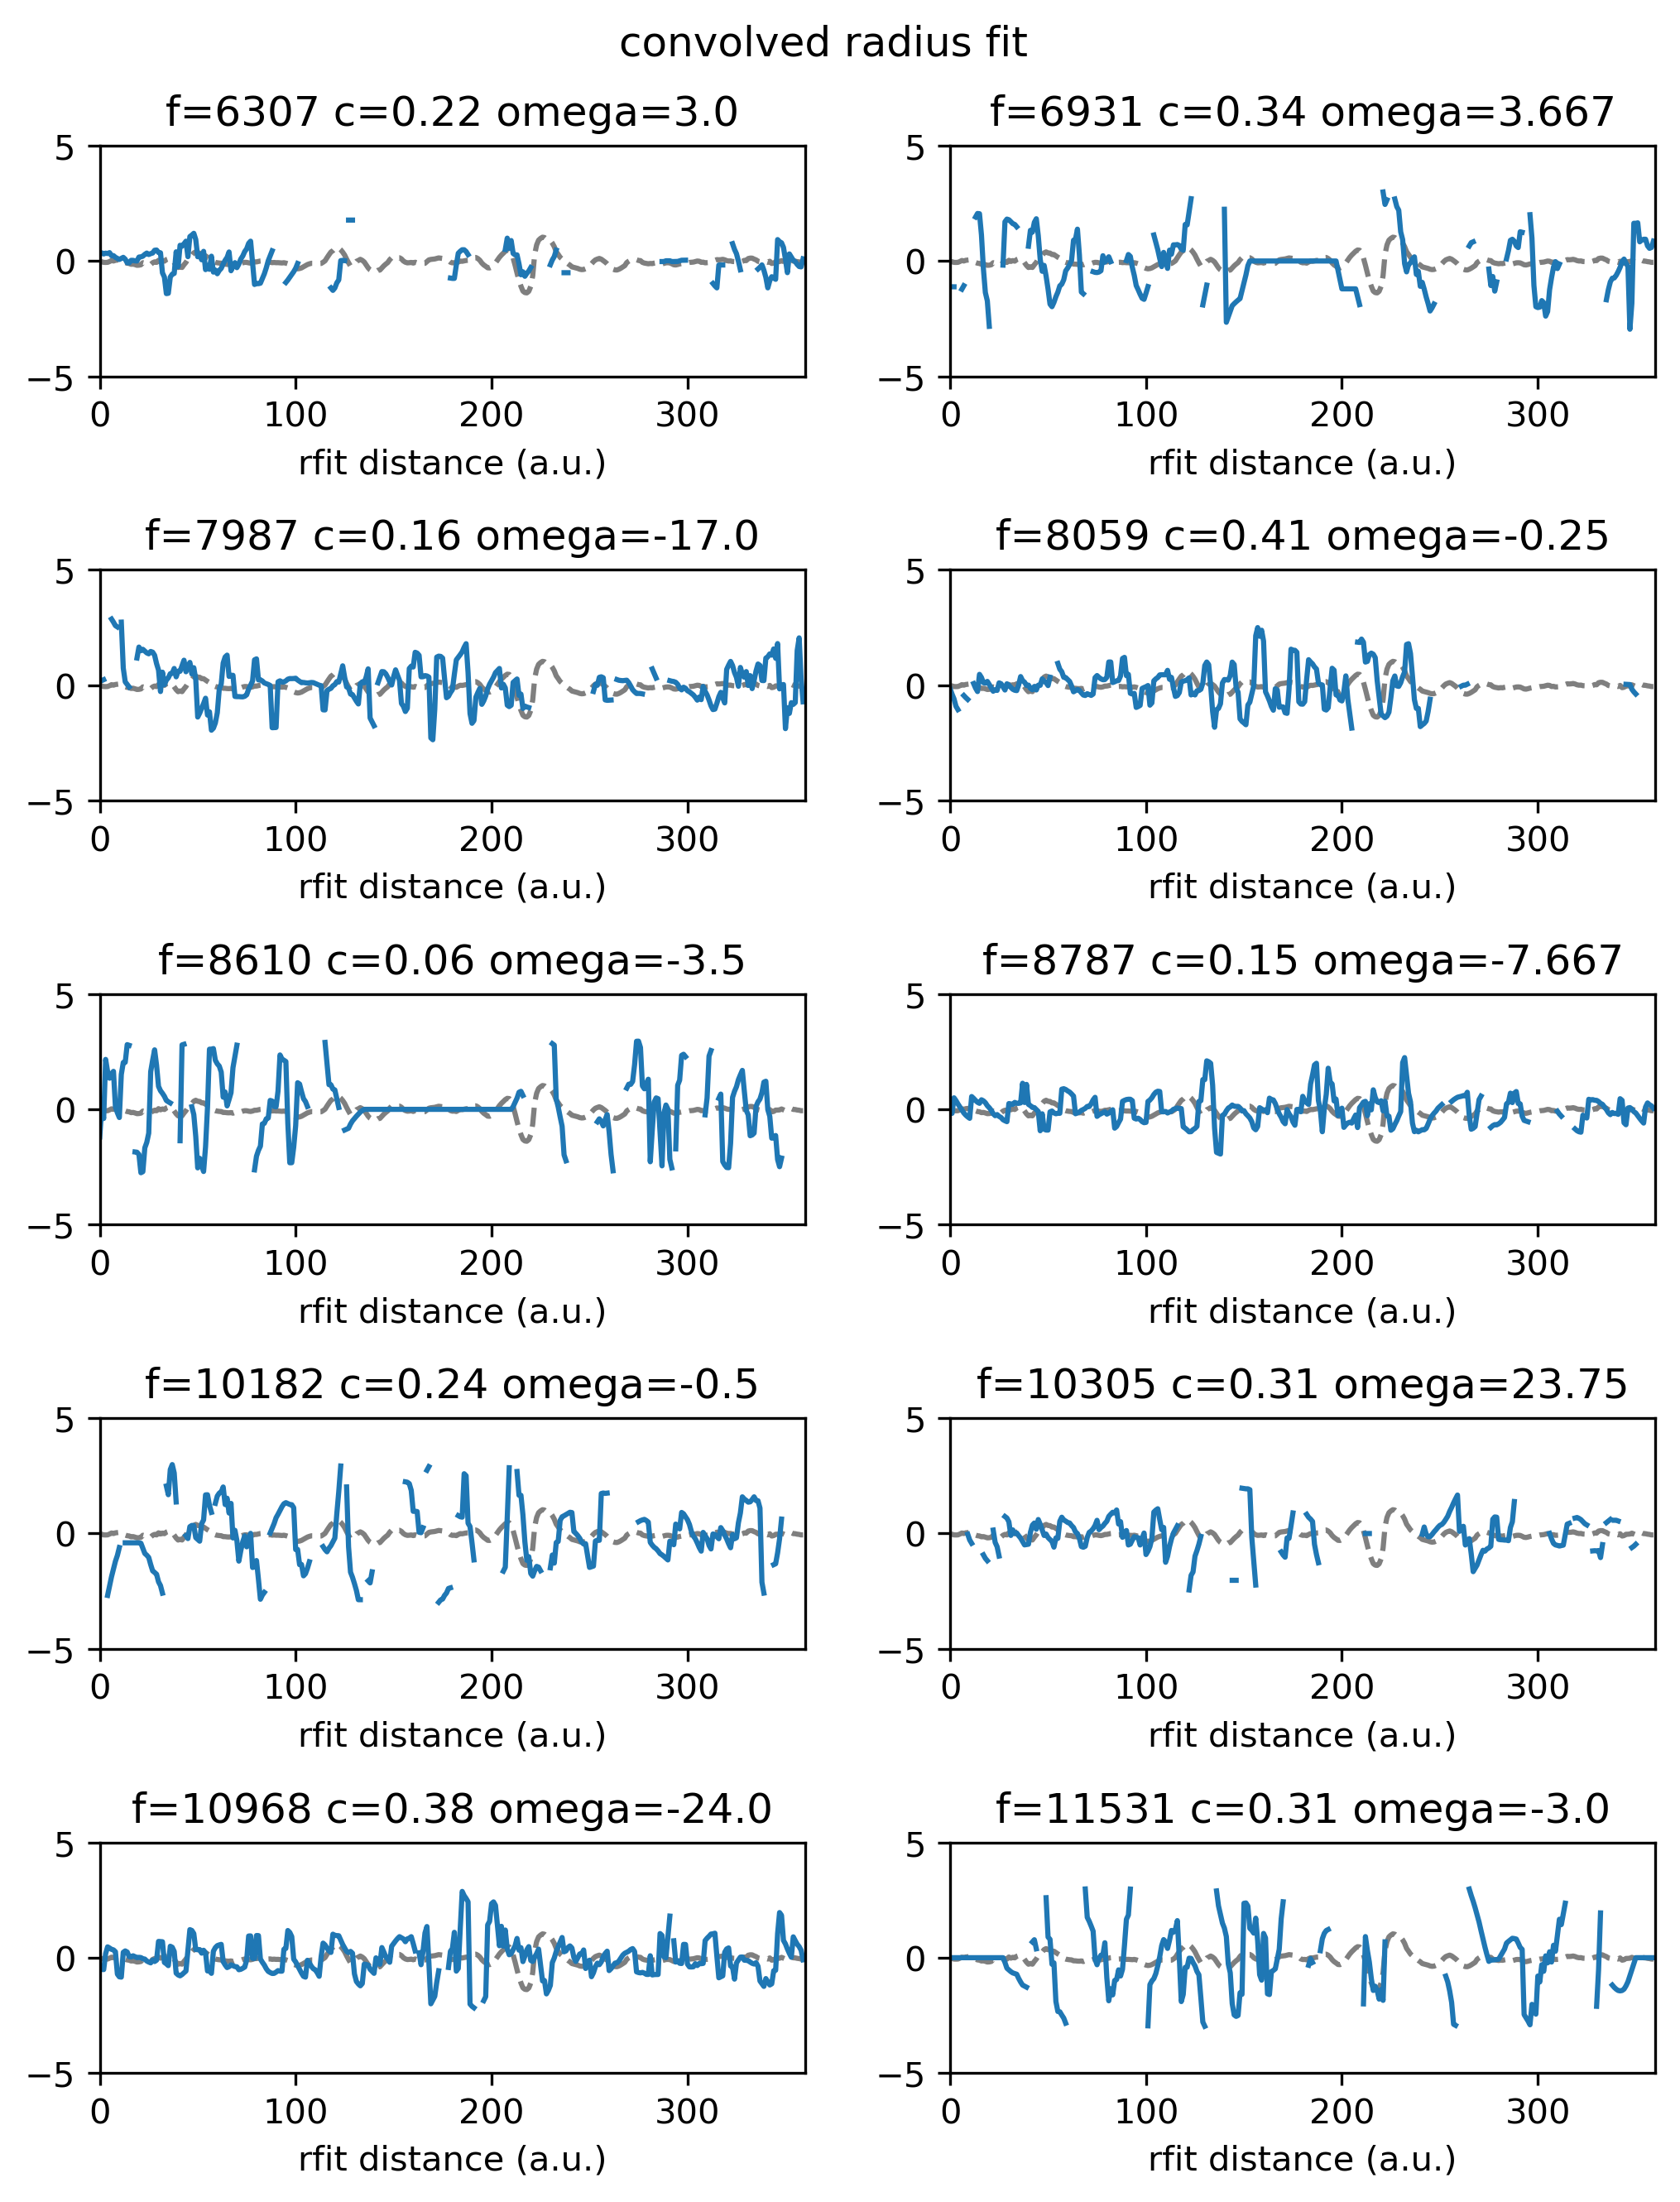

In [62]:
fig, axs = plt.subplots(5,2, dpi=300, figsize=(7,9))
axs = axs.ravel()

rand_frames = sorted(np.random.randint(frame_inds[0], frame_inds[-1]-1, 10))

for i, f in enumerate(rand_frames):
    axs[i].plot(np.arange(len(rad_range)), template, 'k--', alpha=0.5)
    axs[i].plot(np.arange(len(rad_range)), all_conv_rfit[f])
    axs[i].set_title('f={} c={:.2} omega={:.4}'.format(f,c[f-frame_inds[0]], shift_smooth[f-frame_inds[0]]))
    axs[i].set_xlim([0,360])
    axs[i].set_ylim([-5,5])
    axs[i].set_xlabel('radial distance (deg)')
    axs[i].set_xlabel('rfit distance (a.u.)')
fig.suptitle('convolved radius fit')
fig.tight_layout()

In [63]:
# Write diagnostic video
vidsavepath = 'pupil_rotation_test_2.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')

vidout = cv2.VideoWriter(
    vidsavepath,
    fourcc,
    60.0,
    (set_size[0]*2, set_size[1])
)

for i, f in tqdm(enumerate(frame_inds)):

    frame = cv2.cvtColor(eyevid[f,:,:].copy(), cv2.COLOR_GRAY2BGR)
    annotated_frame = cv2.cvtColor(eyevid[f,:,:].copy(), cv2.COLOR_GRAY2BGR)

    current_longaxis = longaxis[f]
    current_shortaxis = shortaxis[f]
    current_centX = centX[f]
    current_centY = centY[f]

    # Plot the ellipse edge
    rmin = 0.5 * (current_longaxis + current_shortaxis) - ranger
    
    for deg_th, rad_th in enumerate(rad_range):

        edge_x = np.round(current_centX + (rmin + all_raw_rfit[f,deg_th]) * np.cos(rad_th))
        edge_y = np.round(current_centY + (rmin + all_raw_rfit[f,deg_th]) * np.sin(rad_th))

        if pd.isnull(edge_x) is False and pd.isnull(edge_y) is False:
            annotated_frame = cv2.circle(annotated_frame, (int(edge_x),int(edge_y)), 1, (50,168,58), thickness=-1)

    # Plot the rotation of the eye as a horizontal line that spans across the pupil made up
    # of 100 circles.
    for d in np.linspace(-0.5, 0.5, 100):

        rot_x = np.round(current_centX + d * (np.rad2deg(np.cos(np.deg2rad(shift_smooth[i])))))
        rot_y = np.round(current_centY + d * (np.rad2deg(np.sin(np.deg2rad(shift_smooth[i])))))

        if pd.isnull(rot_x) is False and pd.isnull(rot_y) is False:
            annotated_frame = cv2.circle(annotated_frame, (int(rot_x), int(rot_y)), 1, (227,32,59), thickness=-1)

    # Plot the center of the eye on the frame as a larger dot than the others
    if pd.isnull(current_centX) is False and pd.isnull(current_centY) is False:

        annotated_frame = cv2.circle(annotated_frame, (int(current_centX), int(current_centY)), 3, (43,52,227), thickness=-1)

    # What was the point of this? Does it do anything important?
    frame_out = np.concatenate([frame, annotated_frame], axis=1)

    vidout.write(frame_out)

vidout.release()

6000it [00:34, 176.26it/s]


In [ ]:
rand_frame_nums = list(np.random.randint(frame_inds[0], frame_inds[-1]-1, size=30))

for step in rand_frame_nums:

    eyevid.set(cv2.CAP_PROP_POS_FRAMES, step)

    eye_ret, eye_frame = eyevid.read()

    if not eye_ret:
        break
    
    plt.subplots(2,2)
    plt.subplot(221)
    plt.imshow(eye_frame.astype(np.uint8),
                cmap='gray')

    # get ellipse parameters for this time
    current_longaxis = eye_longaxis.sel(frame=step).values
    current_shortaxis = eye_shortaxis.sel(frame=step).values
    current_centX = eye_centX.sel(frame=step).values
    current_centY = eye_centY.sel(frame=step).values
    
    # plot the ellipse edge
    rmin = 0.5 * (current_longaxis + current_shortaxis) - ranger
    
    plt.subplot(222)
    plt.imshow(eye_frame.astype(np.uint8), cmap='gray')

    for deg_th in range(0,360):

        rad_th = rad_range[deg_th]

        edge_x = np.round(current_centX
                        + (rmin+rfit_xr.isel(frame=step,deg=deg_th).values)
                        * np.cos(rad_th))

        edge_y = np.round(current_centY
                        + (rmin+rfit_xr.isel(frame=step,deg=deg_th).values)
                        * np.sin(rad_th))

        if pd.isnull(edge_x) is False and pd.isnull(edge_y) is False:
            
            plt.plot(edge_x, edge_y,
                        color='orange', marker='.', markersize=1, alpha=0.1)
    
    # plot the rotation of the eye as a vertical line made up of many circles
    plt.subplot(223)
    plt.imshow(eye_frame.astype(np.uint8), cmap='gray')

    for d in np.linspace(-0.5,0.5,100):

        rot_x = np.round(current_centX + d
                        * (np.rad2deg(np.cos(np.deg2rad(
                        shift_smooth1.isel(frame=step).values)))))

        rot_y = np.round(current_centY + d
                        * (np.rad2deg(np.sin(np.deg2rad(
                        shift_smooth1.isel(frame=step).values)))))

        if pd.isnull(rot_x) is False and pd.isnull(rot_y) is False:
            plt.plot(rot_x, rot_y,
                        color='white', marker='.', markersize=1, alpha=0.1)

    plt.subplot(223)
    plt.imshow(eye_frame.astype(np.uint8), cmap='gray')

    # plot the center of the eye on the frame as a larger dot than the others
    if pd.isnull(current_centX) is False and pd.isnull(current_centY) is False:
        plt.plot(int(current_centX), int(current_centY),
                    color='blue', marker='o')

    plt.subplot(224)
    plt.imshow(eye_frame.astype(np.uint8), cmap='gray')

    for deg_th in range(0,360):

        rad_th = rad_range[deg_th]

        edge_x = np.round(current_centX
                    + (rmin+rfit_xr.isel(frame=step, deg=deg_th).values)
                    * np.cos(rad_th))

        edge_y = np.round(current_centY
                    + (rmin+rfit_xr.isel(frame=step, deg=deg_th).values)
                    * np.sin(rad_th))
        
        if pd.isnull(edge_x) is False and pd.isnull(edge_y) is False:

            plt.plot(edge_x, edge_y,
                        color='orange', marker='.',markersize=1,alpha=0.1)
    
    for d in np.linspace(-0.5, 0.5, 100):
        
        rot_x = np.round(current_centX + d
                        * (np.rad2deg(np.cos(np.deg2rad(
                        shift_smooth1.isel(frame=step).values)))))
        
        rot_y = np.round(current_centY + d
                    * (np.rad2deg(np.sin(np.deg2rad(
                    shift_smooth1.isel(frame=step).values)))))
        
        if pd.isnull(rot_x) is False and pd.isnull(rot_y) is False:
            plt.plot(rot_x, rot_y,
                        color='white', marker='.',markersize=1, alpha=0.1)
            
    # plot the center of the eye on the frame as a larger dot than the others
    if pd.isnull(current_centX) is False and pd.isnull(current_centY) is False:

        plt.plot(int(current_centX), int(current_centY),
                    color='blue', marker='o')

self.shift = shift
self.rfit = rfit_xr
self.rfit_conv = rfit_conv_xr
